In [29]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.utils import save_image
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class voice_face(Dataset):
    def __init__(self, voice_filenames, standardize=False):
        """
        Preconditions: csv files must contain matrices of the same dimension
        Args:
            voice_filenames (string or list): list of filenames/pathnames of csv files with spectrogram matrices
                                              assumes format voice_{n}_{m}.csv, 
                                              where n is the data ID and m is the spectrogram number for that speaker
            standardise (boolean):            whether to standardize the spectrograms
        """
        # ensure inputs are lists
        if type(voice_filenames) == str:
            voice_filenames = [voice_filenames]
        assert(type(voice_filenames) == list)
                
        # load voice spectrograms one by one
        face_IDs = [] # the face IDs associated with each spectrogram
        matrices = [] # the spectrograms
        for v_file in voice_filenames:
            # get n, the data ID 
            n, _ = get_n_m(v_file)
            face_IDs.append(n)
            
            # get spectrogram
            matrix = np.loadtxt(v_file, delimiter=',', dtype=np.float32)
            if standardize:
                matrix = (matrix - np.mean(matrix)) / np.std(matrix)
            matrices.append(matrix)
        
        # construct spectrograms tensor
        self.X = torch.Tensor(matrices)
        N, D, M = self.X.shape
        self.X = self.X.view(N, 1, D, M) # insert channel dimension
        
        # construct face_IDs tensor
        self.y = torch.tensor(face_IDs)
        
        assert(self.X.shape[0] == self.y.shape[0])
        
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [94]:
def get_n_m(v_file):
    v_file = v_file.split('/')[-1] # strip the pathname if it exists
    v_file, _ = v_file.split('.') # strip the file extension
    _, n, m = v_file.split('_') # get n and m from the filename
    return int(n), int(m)

In [4]:
# import dataset
voice_filenames = glob("data/toy_dataset/voicespecs/voice_*")
face_filenames = glob("data/toy_dataset/facespecs/face_*")
dataset = voice_face(voice_filenames, standardize=True)

In [5]:
# split dataset
# TRAIN_SIZE = 9099
# VALID_SIZE = 2000
# TEST_SIZE = 2000
TRAIN_SIZE = 200
VALID_SIZE = 10
TEST_SIZE = 15
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                                                [TRAIN_SIZE, 
                                                                                 VALID_SIZE, 
                                                                                 TEST_SIZE])

In [6]:
# pipe data through a dataloader for batching
BATCH_SIZE = 2
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# class autoencoder(nn.Module):
#     def __init__(self, w_length, face_length):
#         """
#         w_length: the length of the bottleneck vector i.e. # of basis faces used
#         face_length: the height * width of the face images
#         """
#         super(autoencoder, self).__init__()
#         self.encoder = nn.ModuleList(
#             [
#                 nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1), 
#                 nn.ReLU(True),
#                 nn.MaxPool2d(2, stride=2), 
#                 nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
#                 nn.ReLU(True),
#                 nn.MaxPool2d(2, stride=2),
#                 nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
#                 nn.ReLU(True),
#                 nn.MaxPool2d(2, stride=2),
#                 nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
#             ]
#         )
        
#         self.decoder = nn.ModuleList(
#             [
#                 nn.ConvTranspose2d(1, 64, kernel_size=3, stride=1, padding=1), 
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=(1,0),output_padding = (1,0)), 
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=(1,1),output_padding = (1,1)),
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=(1,0), output_padding = (1,0)),
#                 nn.Tanh()
#             ]
#         )
        
#         self.w_length = w_length
#         self.face_length = face_length
#         self.B = nn.Linear(self.w_length, self.face_length, bias=False)

#     def forward(self, x):
#         # start encoder
#         for layer in self.encoder:
#             x = layer.forward(x)
# #             print(x.shape)
        
#         # collapse final feature map into a vector by taking average across time
#         N, _, H, _ = x.shape
#         w = x.mean(dim=3)
#         w = w.view(N, H)
        
#         # start decoder
#         for layer in self.decoder:
#             v = layer.forward(x)
# #             print(v.shape)
            
#         # face construction
#         f = self.B(w)
        
#         return v, f, w

In [ ]:
def conv_shape(L, K, S, P):
    return (L + 2*P - K) // S + 1

In [ ]:
conv_shape(127, 3, 1, 1)

In [7]:
class voice_face_predictor(nn.Module):
    def __init__(self, w_length, face_length):
        """
        w_length: the length of the bottleneck vector i.e. # of basis faces used
        face_length: the height * width of the face images
        """
        super(voice_face_predictor, self).__init__()
        self.encoder = nn.ModuleList(
            [
                                                                            # 1,025 x 251
                nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),        # 1,025 x 251
                nn.ReLU(True),
#                 nn.MaxPool2d(2, stride=2), 
                nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=1),       # 512 x 125
                nn.ReLU(True),
#                 nn.MaxPool2d(2, stride=2),
                nn.Conv2d(16, 64, kernel_size=5, stride=2, padding=1),      # 255 x 62
                nn.ReLU(True),
                nn.MaxPool2d(2, stride=2),                                  # 127 x 31
                nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)        # 127 x 31
            ]
        )
        
#         self.decoder = nn.ModuleList(
#             [
#                 nn.ConvTranspose2d(1, 64, kernel_size=3, stride=1, padding=1), 
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=(1,0),output_padding = (1,0)), 
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=(1,1),output_padding = (1,1)),
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=(1,0), output_padding = (1,0)),
#                 nn.Tanh()
#             ]
#         )
        
        self.w_length = 127
        self.face_length = face_length
        self.B = nn.Linear(self.w_length, self.face_length, bias=False)

    def forward(self, x):
        # start encoder
        for layer in self.encoder:
            x = layer.forward(x)
#             print(x.shape)
        
        # collapse final feature map into a vector by taking average across time
        N, _, H, _ = x.shape
        w = x.mean(dim=3)
        w = w.view(N, H)
        
#         # start decoder
#         for layer in self.decoder:
#             v = layer.forward(x)
# #             print(v.shape)
            
        # face construction
        f = self.B(w)
        
#         return v, f, w
        return f, w

In [8]:
ALPHA = 1
def combined_loss(model_output,labels):
    voice_output, face_output = model_output
    
    voice_data, face_id = labels
    face_data = face_struct[face_id]
    
    loss = fid(face_output, face_data) + ALPHA * MSE(voice_output, voice_data)
    return loss

# def face_loss(face_outputs, labels):
#     true_faces = face_struct[labels]
# #     loss = fid(face_output, true_faces)
# #     loss = torch.dist(face_output, true_faces, p=2) ** 2 # squared L2 norm
#     loss = MSE(face_output, true_faces)
#     return loss

def face_loss(face_outputs, labels):
    true_faces = []
    for i in labels:
        face = np.loadtxt("data/toy_dataset/facespecs/face_"+str(i.item()),delimiter=',')
        face = face.reshape(face.shape[0]*face.shape[1])
        true_faces.append(face)
    true_faces = torch.Tensor(true_faces)

#    true_faces = face_struct[labels]
#     loss = fid(face_output, true_faces)
#     loss = torch.dist(face_output, true_faces, p=2) ** 2 # squared L2 norm
    loss = MSE(face_outputs, true_faces)
    return loss

In [ ]:
# # model = autoencoder().cuda()
# NUM_EPOCHS = 10
# LEARNING_RATE = 1e-3
# model = autoencoder()
# MSE = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [ ]:
# for data in dataloader:
#     temp = data
#     break

In [ ]:
# temp.shape

In [ ]:
# for epoch in range(NUM_EPOCHS):
#     for batch in dataloader:
#         # ===================forward=====================
#         voice, face_id = batch
#         voice_output, face_output, w = model(voice)
#         loss = combined_loss((voice_output,face_output), (voice,face_id))
#         # ===================backward====================
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     # ===================log========================
#     if((epoch+1)%10 == 0):
#         print('epoch [{}/{}], loss:{:.4f}'
#               .format(epoch+1, NUM_EPOCHS, loss.data.item()))

# torch.save(model.state_dict(), './model_state.pth')

In [56]:
# model = autoencoder().cuda()
NUM_EPOCHS = 70
LEARNING_RATE = 1e-3
model = voice_face_predictor(w_length = 128, face_length = 128*128)
MSE = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [58]:
# train just for faces
for epoch in range(NUM_EPOCHS):
    for batch in dataloader:
        # ===================forward=====================
        voice, face_ID = batch
        face_output, w = model(voice)
        loss = face_loss(face_output, face_ID)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
#     if((epoch+1)%10 == 0):
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, NUM_EPOCHS, loss.data.item()))

torch.save(model.state_dict(), './model_state.pth')

epoch [1/70], loss:376.4898
epoch [2/70], loss:375.4358
epoch [3/70], loss:411.3645
epoch [4/70], loss:284.4101
epoch [5/70], loss:286.3305
epoch [6/70], loss:484.6804
epoch [7/70], loss:172.2750
epoch [8/70], loss:246.4384
epoch [9/70], loss:445.7521
epoch [10/70], loss:193.3315
epoch [11/70], loss:140.0689
epoch [12/70], loss:155.9243
epoch [13/70], loss:307.1885
epoch [14/70], loss:214.4554
epoch [15/70], loss:110.0945
epoch [16/70], loss:216.5282
epoch [17/70], loss:252.4993
epoch [18/70], loss:300.9217
epoch [19/70], loss:323.4555
epoch [20/70], loss:358.8651
epoch [21/70], loss:28.9149
epoch [22/70], loss:298.2451
epoch [23/70], loss:255.9261
epoch [24/70], loss:58.6008
epoch [25/70], loss:304.1813
epoch [26/70], loss:63.8571
epoch [27/70], loss:186.3317
epoch [28/70], loss:186.8598
epoch [29/70], loss:262.8623
epoch [30/70], loss:345.8340
epoch [31/70], loss:260.3000
epoch [32/70], loss:143.1462
epoch [33/70], loss:56.5054
epoch [34/70], loss:272.1576
epoch [35/70], loss:221.231

In [86]:
test_voice, test_face_ID = test_dataset[5]

In [87]:
test_face_ID = test_face_ID.item()
test_face = np.loadtxt("data/toy_dataset/facespecs/face_"+str(test_face_ID), delimiter=',')

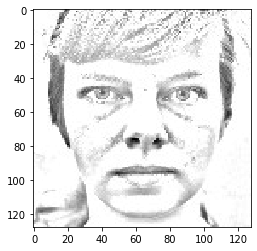

In [88]:
plt.imshow(test_face, cmap="gray")

In [89]:
temp_f, temp_w = model(test_voice.view([1, 1, 1025, 251])) # run through model

In [90]:
temp_f_arr = temp_f.detach().numpy() # convert to numpy array

In [91]:
temp_f_arr = temp_f_arr.reshape((128,128))

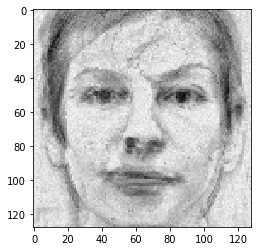

In [46]:
plt.imshow(temp_f_arr, cmap="gray")

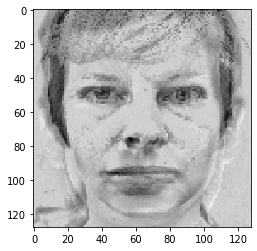

In [92]:
plt.imshow(temp_f_arr, cmap="gray")

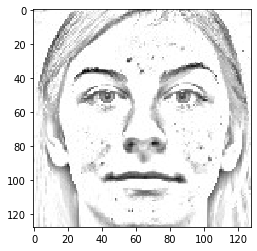

In [50]:
plt.imshow(np.loadtxt("data/toy_dataset/facespecs/face_0", delimiter=','), cmap="gray")

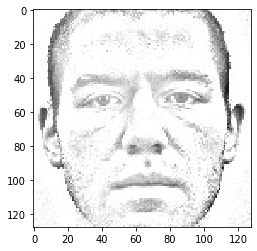

In [51]:
plt.imshow(np.loadtxt("data/toy_dataset/facespecs/face_1", delimiter=','), cmap="gray")

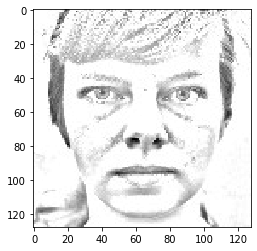

In [52]:
plt.imshow(np.loadtxt("data/toy_dataset/facespecs/face_2", delimiter=','), cmap="gray")

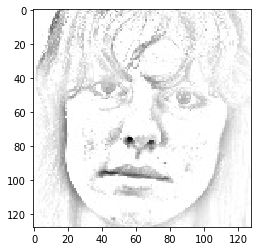

In [53]:
plt.imshow(np.loadtxt("data/toy_dataset/facespecs/face_3", delimiter=','), cmap="gray")

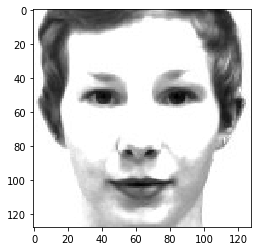

In [54]:
plt.imshow(np.loadtxt("data/toy_dataset/facespecs/face_4", delimiter=','), cmap="gray")

In [ ]:
# Check that NN outputs the same size file as input
# FID for similarity between faces

In [95]:
# import dataset
voice_filenames = glob("data/Voice_to_face/voicespecs/voice_*")
face_filenames = glob("data/Voice_to_face/facespecs/face_*")
dataset = voice_face(voice_filenames, standardize=True)

In [97]:
# split dataset
# TRAIN_SIZE = 9099
# VALID_SIZE = 2000
# TEST_SIZE = 2000
TRAIN_SIZE = 3000
VALID_SIZE = 300
TEST_SIZE = 300
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                                                [TRAIN_SIZE, 
                                                                                 VALID_SIZE, 
                                                                                 TEST_SIZE])

In [98]:
# pipe data through a dataloader for batching
BATCH_SIZE = 10
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [99]:
class voice_face_predictor(nn.Module):
    def __init__(self, w_length, face_length):
        """
        w_length: the length of the bottleneck vector i.e. # of basis faces used
        face_length: the height * width of the face images
        """
        super(voice_face_predictor, self).__init__()
        self.encoder = nn.ModuleList(
            [
                                                                            # 1,025 x 251
                nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),        # 1,025 x 251
                nn.ReLU(True),
#                 nn.MaxPool2d(2, stride=2), 
                nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=1),       # 512 x 125
                nn.ReLU(True),
#                 nn.MaxPool2d(2, stride=2),
                nn.Conv2d(16, 64, kernel_size=5, stride=2, padding=1),      # 255 x 62
                nn.ReLU(True),
                nn.MaxPool2d(2, stride=2),                                  # 127 x 31
                nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)        # 127 x 31
            ]
        )
        
#         self.decoder = nn.ModuleList(
#             [
#                 nn.ConvTranspose2d(1, 64, kernel_size=3, stride=1, padding=1), 
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=(1,0),output_padding = (1,0)), 
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=(1,1),output_padding = (1,1)),
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=(1,0), output_padding = (1,0)),
#                 nn.Tanh()
#             ]
#         )
        
        self.w_length = 127
        self.face_length = face_length
        self.B = nn.Linear(self.w_length, self.face_length, bias=False)

    def forward(self, x):
        # start encoder
        for layer in self.encoder:
            x = layer.forward(x)
#             print(x.shape)
        
        # collapse final feature map into a vector by taking average across time
        N, _, H, _ = x.shape
        w = x.mean(dim=3)
        w = w.view(N, H)
        
#         # start decoder
#         for layer in self.decoder:
#             v = layer.forward(x)
# #             print(v.shape)
            
        # face construction
        f = self.B(w)
        
#         return v, f, w
        return f, w

In [105]:
ALPHA = 1
def combined_loss(model_output,labels):
    voice_output, face_output = model_output
    
    voice_data, face_id = labels
    face_data = face_struct[face_id]
    
    loss = fid(face_output, face_data) + ALPHA * MSE(voice_output, voice_data)
    return loss

# def face_loss(face_outputs, labels):
#     true_faces = face_struct[labels]
# #     loss = fid(face_output, true_faces)
# #     loss = torch.dist(face_output, true_faces, p=2) ** 2 # squared L2 norm
#     loss = MSE(face_output, true_faces)
#     return loss

def face_loss(face_outputs, labels):
    true_faces = []
    for i in labels:
        face = np.loadtxt("data/Voice_to_face/facespecs/face_{}.csv".format(i.item()),delimiter=',')
        face = face.reshape(face.shape[0]*face.shape[1])
        true_faces.append(face)
    true_faces = torch.Tensor(true_faces)

#    true_faces = face_struct[labels]
#     loss = fid(face_output, true_faces)
#     loss = torch.dist(face_output, true_faces, p=2) ** 2 # squared L2 norm
    loss = MSE(face_outputs, true_faces)
    return loss

In [101]:
# model = autoencoder().cuda()
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
model = voice_face_predictor(w_length = 128, face_length = 128*128)
MSE = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [109]:
# train just for faces
for epoch in range(NUM_EPOCHS):
    for batch in dataloader:
        # ===================forward=====================
        voice, face_ID = batch
        face_output, w = model(voice)
        loss = face_loss(face_output, face_ID)
        # bases 
        # loss_bases_val = loss_bases(bases, target_bases)
        # total_loss = loss+loss_bases_val 
        # total_loss.backward()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # ===================log========================
#     if((epoch+1)%10 == 0):
    print('epoch [{}/{}], loss:{:.4f}, completed at {}'
          .format(epoch+1, NUM_EPOCHS, loss.data.item(), datetime.now()))

torch.save(model.state_dict(), './model_state.pth')

epoch [1/30], loss:720.9661, completed at 2019-11-25 22:59:18.853276
epoch [2/30], loss:603.3151, completed at 2019-11-25 23:09:10.907005
epoch [3/30], loss:547.5021, completed at 2019-11-25 23:19:55.696181
epoch [4/30], loss:778.9558, completed at 2019-11-25 23:29:51.694030
epoch [5/30], loss:643.2377, completed at 2019-11-25 23:39:51.155675
epoch [6/30], loss:704.1285, completed at 2019-11-25 23:49:40.579907
epoch [7/30], loss:802.6552, completed at 2019-11-25 23:59:22.983281
epoch [8/30], loss:568.2654, completed at 2019-11-26 00:09:25.335841
epoch [9/30], loss:503.0205, completed at 2019-11-26 00:19:12.065493
epoch [10/30], loss:660.3054, completed at 2019-11-26 00:29:00.094441
epoch [11/30], loss:758.2507, completed at 2019-11-26 00:38:02.951600
epoch [12/30], loss:563.1929, completed at 2019-11-26 00:46:45.681962
epoch [13/30], loss:645.9363, completed at 2019-11-26 00:55:32.155918
epoch [14/30], loss:511.5188, completed at 2019-11-26 01:04:11.110787
epoch [15/30], loss:485.8408,

In [182]:
test_voice, test_face_ID = test_dataset[2]

In [183]:
test_face = np.loadtxt("data/Voice_to_face/facespecs/face_{}.csv".format(test_face_ID), delimiter=',')

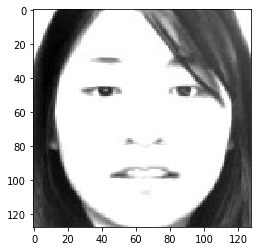

In [184]:
plt.imshow(test_face, cmap="gray")

In [185]:
temp_f, temp_w = model(test_voice.view([1, 1, 1025, 251])) # run through model
temp_f_arr = temp_f.detach().numpy() # convert to numpy array
temp_f_arr = temp_f_arr.reshape((128,128))

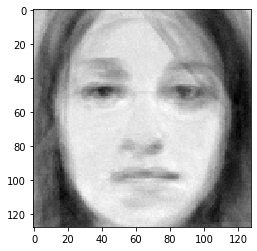

In [186]:
plt.imshow(temp_f_arr, cmap="gray")